# RNN for Smoothed Sunspot Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Data/SVG_poly1.csv') # importing data for SVG polyorder = 1
X = ((df.Year).values).reshape(-1,1)
y = (df.Sunspot_Number).values
yerr = np.zeros(len(X))

df.drop(columns=['Unnamed: 0'], inplace=True)
df.drop(columns=['Year'], inplace=True)

df.head()

,Sunspot_Number
0,34.566570
1,34.546053
2,34.525535
3,34.505017
4,34.484499


## Data Preprocessing

In [3]:
train = df.iloc[:70000:10]
test = df.iloc[70000::10]

In [4]:
train

,Sunspot_Number
0,34.566570
10,34.361393
20,34.156216
30,33.951039
40,33.745862
...,...
69950,16.791923
69960,17.114990
69970,17.515400
69980,18.072553


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [6]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [7]:
from keras.preprocessing.sequence import TimeseriesGenerator

2023-02-02 14:50:04.149757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# define generator
n_input = 12 
n_features = 1 # we are only using 1 timeseries to make our predictions
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [9]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

X.shape

Given the Array: 
[0.12604796 0.12518466 0.12432136 0.12345807 0.12259477 0.12173147
 0.12086817 0.12000487 0.11914158 0.11827828 0.11741498 0.11655168]
Predict this y: 
 [[0.11568838]]


(1, 12, 1)

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [11]:
# define model
model = Sequential() # adds layers in a sequence
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
# 100 neurons
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


2023-02-02 14:50:07.679599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# fit model
model.fit(generator,epochs=10)

Epoch 1/10
6988/6988 [==============================] - 27s 4ms/step - loss: 4.2472e-04
Epoch 2/10
6988/6988 [==============================] - 26s 4ms/step - loss: 3.7804e-05
Epoch 3/10
6988/6988 [==============================] - 27s 4ms/step - loss: 2.4163e-05
Epoch 4/10
6988/6988 [==============================] - 24s 3ms/step - loss: 1.9103e-05
Epoch 5/10
6988/6988 [==============================] - 25s 4ms/step - loss: 1.5948e-05
Epoch 6/10
6988/6988 [==============================] - 37s 5ms/step - loss: 1.4679e-05
Epoch 7/10
6988/6988 [==============================] - 47s 7ms/step - loss: 1.4116e-05
Epoch 8/10
6988/6988 [==============================] - 44s 6ms/step - loss: 1.1274e-05
Epoch 9/10
6988/6988 [==============================] - 25s 4ms/step - loss: 9.9209e-06
Epoch 10/10
6988/6988 [==============================] - 26s 4ms/step - loss: 9.8676e-06


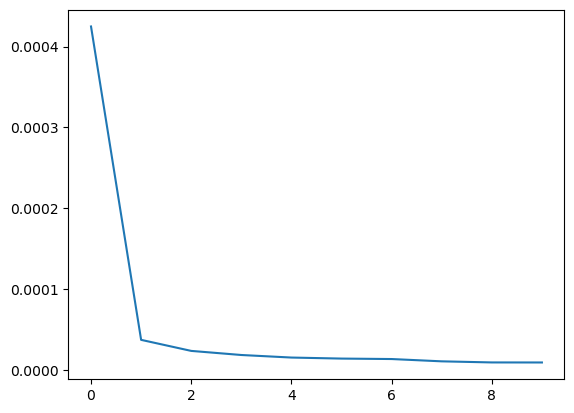

In [13]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [14]:
last_train_batch = scaled_train[-n_input:] 
# take the last n_input month of values, to make 
# predictions on the 1st test set

In [15]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [16]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 162ms/step


array([[0.05826316]], dtype=float32)

In [17]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 32ms/step


In [18]:
test_predictions
# NOTE: these predictions are in the range 0-1
# we need to convert it back 

[array([0.05826316], dtype=float32),
 array([0.05911547], dtype=float32),
 array([0.05982441], dtype=float32),
 array([0.06041197], dtype=float32),
 array([0.06089265], dtype=float32),
 array([0.0612871], dtype=float32),
 array([0.06161656], dtype=float32),
 array([0.06188859], dtype=float32),
 array([0.06211403], dtype=float32),
 array([0.06229877], dtype=float32),
 array([0.06244997], dtype=float32),
 array([0.06257162], dtype=float32),
 array([0.0626699], dtype=float32),
 array([0.06274857], dtype=float32),
 array([0.06281072], dtype=float32),
 array([0.06285914], dtype=float32),
 array([0.06289616], dtype=float32),
 array([0.06292356], dtype=float32),
 array([0.06294298], dtype=float32),
 array([0.06295583], dtype=float32),
 array([0.06296325], dtype=float32),
 array([0.0629662], dtype=float32),
 array([0.06296553], dtype=float32),
 array([0.06296191], dtype=float32),
 array([0.06295592], dtype=float32),
 array([0.06294805], dtype=float32),
 array([0.06293872], dtype=float32),
 arr

In [19]:
true_predictions = scaler.inverse_transform(test_predictions)

In [20]:
test['Sunspot Number'] = true_predictions

/var/folders/42/2w7j46nn3j75crpy2kc1y7vw0000gn/T/ipykernel_4471/3433122075.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Sunspot Number'] = true_predictions


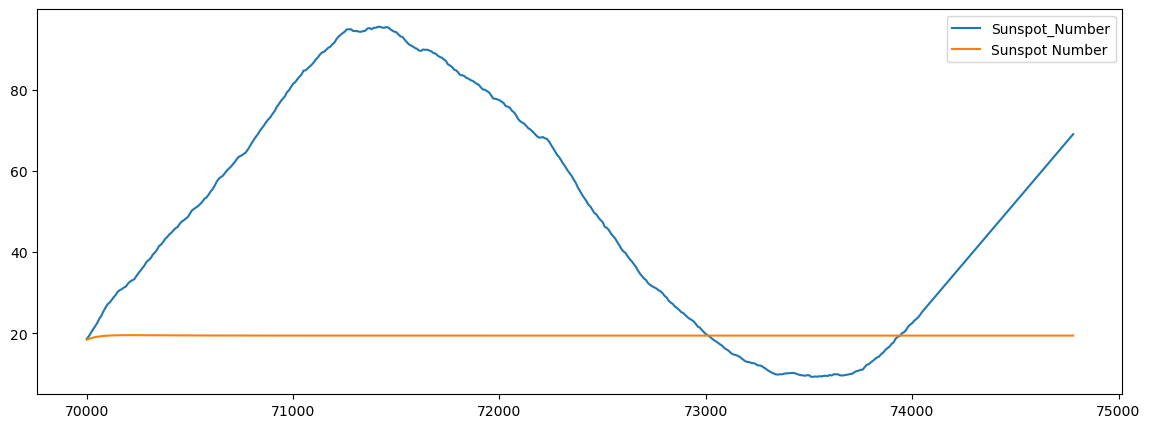

In [21]:
test.plot(figsize=(14,5));